# Protein Binding

This notebook aims to reproduce the results of: 
 - Kovacev-Nikolic V, Bubenik P, Nikolić D, Heo G. _Using persistent homology and dynamical distances to analyze protein binding._ Statistical Applications in Genetics and Molecular Biology, 15(1). (2016)

This paper develops a classification algorithm of the different shapes of the protein **MBP (maltose-binding protein)** based on the computation of Persistent Homology.


![SegmentLocal](../figures/animated_Maltose-binding_protein_b.gif "segment") 

Figure: E. coli maltose-binding protein complex with maltose (PDB entry 1anf) .

### 1. The problem

The **maltose-binding protein** is a bacterial protein found in **Escherichia coli** where its primary
function is to __bind and transport sugar molecules__ across cell membranes, providing energy
to the bacterium (Boos & Shuman, 1998). Though sometimes causing serious illness, most
strains of E. coli are nonpathogenic and in fact beneficial. These bacteria colonize the
gastrointestinal tract of humans and animals and protect the gut from harmful bacteria
(Hudault et al., 2001). Furthermore, E. coli is the best known living organism and is used
to study various cellular processes (Van Houdt & Michiels, 2005). 

While performing biological functions, the MBP **changes its structure**. A major conformational change in the protein occurs when a smaller molecule called a
**ligand** attaches to the protein molecule. Szmelcman et al. (1976) determined
that the MBP interacts with various sugar molecules (ligands), starting from the small
maltose molecule through the larger maltodextrin. **Ligand-induced conformational changes**
are important because the **biological function** of the protein occurs through a transition from
a ligand-free (apo) to a ligand-bound (holo) structure (Seeliger & de Groot, 2010).

Simulations and to some extent experiments show that 95% of the time the two domains
of MBP are separated and twisted, which is called an **open conformation**, and 5% of the
time they are close to each other, which is called a **closed conformation**. If closed, it is
always due to having a captured ligand. Open structures can have an attached
ligand or not.


![title](../figures/open-closed.png)

Figure from _Maltose-binding protein: a versatile platform for prototyping biosensing._ Curr Opin Biotechnol. 2006 Feb;17(1):17-27

### 2. The data

While performing biological functions, the MBP **changes its structure**. Our objects of
study are fourteen three-dimensional structures of the MBP, obtained by **X-ray crystallography**. The structures are available from the **Protein Data Bank**, Bernstein et al. (1977). 

Each
structure is a large biomolecule with about 3000 heavy atoms grouped into 370 relatively
small clusters representing amino acid **residues**.

**Example:**  https://www.rcsb.org/structure/1anf 

#### Dynamical model

- Nikolić, D. and V. Kovacev-Nikolic (2013). **Dynamical model of the maltose-binding protein**.

### 3. Correlation metric

The analysis is not based on the geometric structure inherited from the embedding of the protein in the Euclidean space $\mathbb R^3$, but on a _dinamical distance_ between the residues, defined as: 
$$D_{ij} = 1 - |C_{ij}|,$$
where $C$ is the correlation matrix between residues.
The matrix $C$ is available at [link](https://www.researchgate.net/publication/301543862_corr).


Let's see as an example the structure of the distance matrix of the protein **1anf**.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install biopython
from Bio.PDB import *

In [2]:
corr = np.loadtxt('../data/Corr_ProteinBinding/1anf.corr_1.txt')

In [3]:
dist = 1- np.abs(corr)

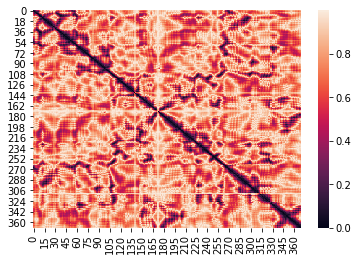

In [4]:
sns.heatmap(dist)
plt.show()

### 4. Persistent Homology

We use the argument _distance_matrix = True_ when computing persistent homology from a **distance matrix** description of a metric space.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


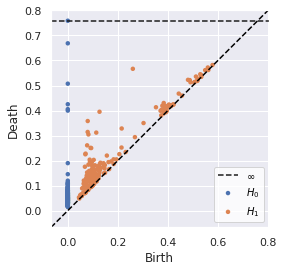

In [5]:
from ripser import Rips

sns.set()
rips = Rips()
dgms = rips.fit_transform(dist, distance_matrix = True)
rips.plot(dgms)

We compute the distance matrix between residues for different structures of the protein MBP.

In [6]:
path_file = "../data/Corr_ProteinBinding/"
files_list = [
'1anf.corr_1.txt',
'1ez9.corr_1.txt',
'1fqa.corr_2.txt',
'1fqb.corr_3.txt',
'1fqc.corr_2.txt',
'1fqd.corr_3.txt',
'1jw4.corr_4.txt',
'1jw5.corr_5.txt',
'1lls.corr_6.txt',
'1mpd.corr_4.txt',
'1omp.corr_7.txt',
'3hpi.corr_5.txt',
'3mbp.corr_6.txt',
'4mbp.corr_7.txt']

corr_list = [pd.read_csv(path_file+u,
                         header=None,
                         delim_whitespace=True) for u in files_list]

dist_list = [1- np.abs(c) for c in corr_list]

We compute then the persistence diagram for every structure.

In [8]:
#!pip install gudhi
import gudhi as gd 

persistence_list0 = []
persistence_list1 = []

for d in dist_list:
    rips_complex = gd.RipsComplex(distance_matrix=d.values, max_edge_length=0.8)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    persistence_list0.append(simplex_tree.persistence_intervals_in_dimension(0))
    persistence_list1.append(simplex_tree.persistence_intervals_in_dimension(1))

Finally, we analize the metric space of persistence diagrams of the structures of the protein (for every degree), endowed with the bottleneck distance.

In [9]:
l = len(files_list)
B0= np.zeros((l,l))
B1 =np.zeros((l,l))
for i in range(l):
    for j in range(i):
        B0[i,j] = gd.bottleneck_distance(persistence_list0[i], persistence_list0[j])
        B1[i,j] = gd.bottleneck_distance(persistence_list1[i], persistence_list1[j])
B0 = B0 + B0.transpose()
B1 = B1 + B1.transpose()

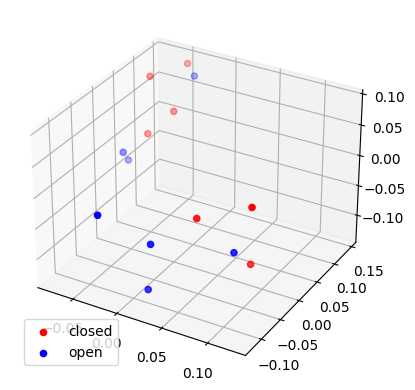

In [11]:
from sklearn.manifold import MDS

mds = MDS(n_components=3, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(B0).embedding_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[0:7,0], pos[0:7, 1],pos[0:7, 2],  color='red', label="closed")
ax.scatter(pos[7:l,0], pos[7:l, 1],pos[7:l, 2], color='blue', label="open")
ax.legend( loc=3, borderaxespad=1);

It turns out that the diagrams corresponding to proteins with open structure and closed structure can be classified using _LinearSVM_.

<img src="../figures/SVM.jpg" width="800">